<a href="https://colab.research.google.com/github/folukeOpenuni/Cloud-AI-masters/blob/main/CloudAI_CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required Libraries

In [ ]:
!pip install --upgrade holoviews
!pip install shap
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import holoviews as hv
import seaborn as sns
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from IPython.display import HTML, display
import holoviews as hv
hv.extension('bokeh')
import panel as pn
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import shap
from google.colab import drive
drive.mount('/content/drive')
from google.colab import drive

# Data Exploration and pre-processing

In [35]:
drive.mount('/gdrive')
%cd /gdrive/MyDrive/CloudAI
fn = '/gdrive/MyDrive/CloudAI/HomeC.csv'
df = pd.read_csv(fn, low_memory=False)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/CloudAI


In [36]:
df.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

In [37]:
df.columns = [i.replace(' [kW]', '') for i in df.columns]

In [38]:
df.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Furnace 1',
       'Furnace 2', 'Home office', 'Fridge', 'Wine cellar', 'Garage door',
       'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')

In [39]:
# df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
# df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
# df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','summary'], axis=1, inplace=True)
#find all nan value
df[df.isnull().any(axis=1)]

,time,use,gen,House overall,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
503910,\,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
#remove nan value
df = df[0:-1]

In [41]:
#find invalide rows - There are invalid values in cloudCover column because it must be float64-type but it is object-type.
#return a list containing all the distinct values found in the "cloudCover" column
df['cloudCover'].unique()

array(['cloudCover', '0.75', '0', '1', '0.31', '0.44', '0.13', '0.19',
       '0.25', '0.16', '0.21', '0.15', '0.14', '0.27', '0.28', '0.17',
       '0.05', '0.1', '0.26', '0.29', '0.11', '0.09', '0.12', '0.06',
       '0.02', '0.08', '0.04', '0.35', '0.22', '0.23', '0.54', '0.39',
       '0.03', '0.07', '0.76', '0.62', '0.18', '0.79', '0.48', '0.24',
       '0.57', '0.41', '0.78', '0.2', '0.77', '0.46', '0.55', '0.01',
       '0.51', '0.47', '0.5', '0.4', '0.3', '0.43', '0.33', '0.6', '0.68',
       '0.66', '0.45', '0.34', '0.52', '0.67', '0.49', '0.37', '0.36',
       '0.61', '0.38', '0.42', '0.53', '0.63', '0.32', '0.56', '0.58',
       '0.72', '0.73', '0.71', '0.64', '0.59'], dtype=object)

In [42]:
df = df.loc[:]  # Explicitly create a view of the entire DataFrame

# Perform operations directly on the DataFrame
df.loc[:, 'cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df.loc[:, 'cloudCover'] = df.loc[:, 'cloudCover'].astype('float')

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [43]:
df['cloudCover'].unique()

array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ,
       0.68, 0.66, 0.45, 0.34, 0.52, 0.67, 0.49, 0.37, 0.36, 0.61, 0.38,
       0.42, 0.53, 0.63, 0.32, 0.56, 0.58, 0.72, 0.73, 0.71, 0.64, 0.59])

In [44]:
#Date info - create new daterange in increments of minutes.
df['time'] = pd.DatetimeIndex(pd.date_range('2016-01-01 05:00', periods=len(df),  freq='min'))
df.head(2)

,time,use,gen,House overall,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.12415,0.006983,...,10.0,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0
1,2016-01-01 05:01:00,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.12400,0.006983,...,10.0,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0


In [45]:
#Extract year, month, and day from the 'time' column for EDA and model features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['weekday'] = df['time'].dt.day_name()
df['weekofyear'] = df['time'].dt.isocalendar().week
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df.head(2)

,time,use,gen,House overall,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,...,precipIntensity,dewPoint,precipProbability,year,month,day,weekday,weekofyear,hour,minute
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.12415,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,53,5,0
1,2016-01-01 05:01:00,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.12400,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,53,5,1


In [46]:
def hours2timing(x):
    bins = [0, 4, 12, 17, 22, 24]
    labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']
    index = np.digitize(x % 24, bins, right=True)

    # Handle the circular nature of time
    index = (index - 1) % len(labels)

    return labels[index]


#create timing column
df['timing'] = df['hour'].apply(hours2timing)
df.head(3)

,time,use,gen,House overall,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,...,dewPoint,precipProbability,year,month,day,weekday,weekofyear,hour,minute,timing
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,24.4,0.0,2016,1,1,Friday,53,5,0,Morning
1,2016-01-01 05:01:00,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,24.4,0.0,2016,1,1,Friday,53,5,1,Morning
2,2016-01-01 05:02:00,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,24.4,0.0,2016,1,1,Friday,53,5,2,Morning


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


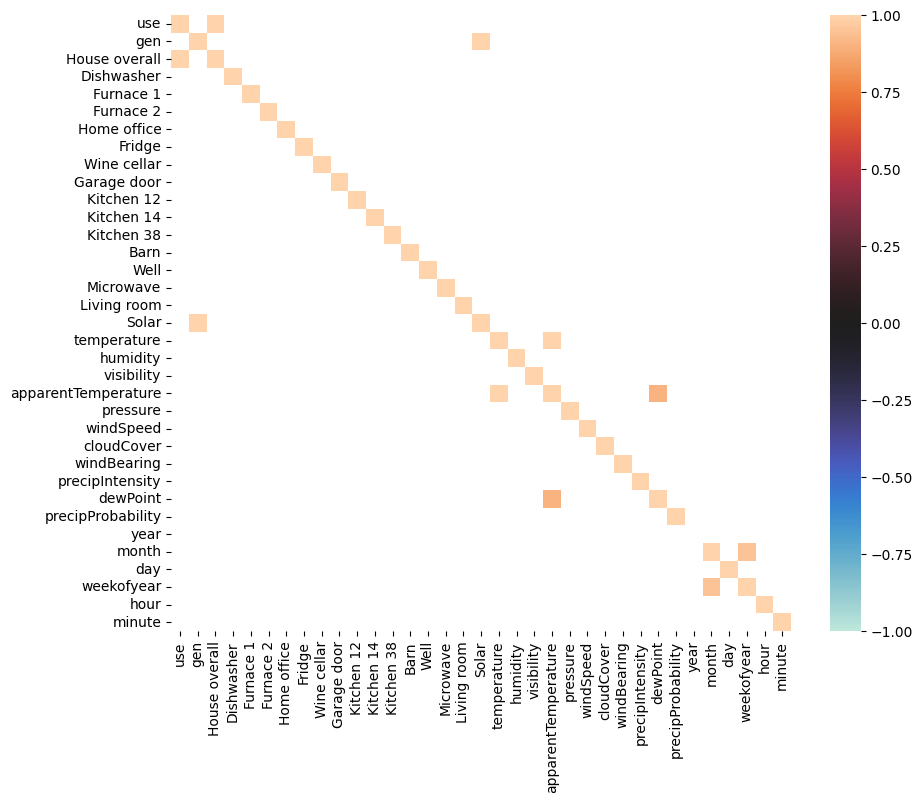

In [47]:
fig = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr[corr>0.9], vmax=1, vmin=-1, center=0)
plt.show()

<Axes: >

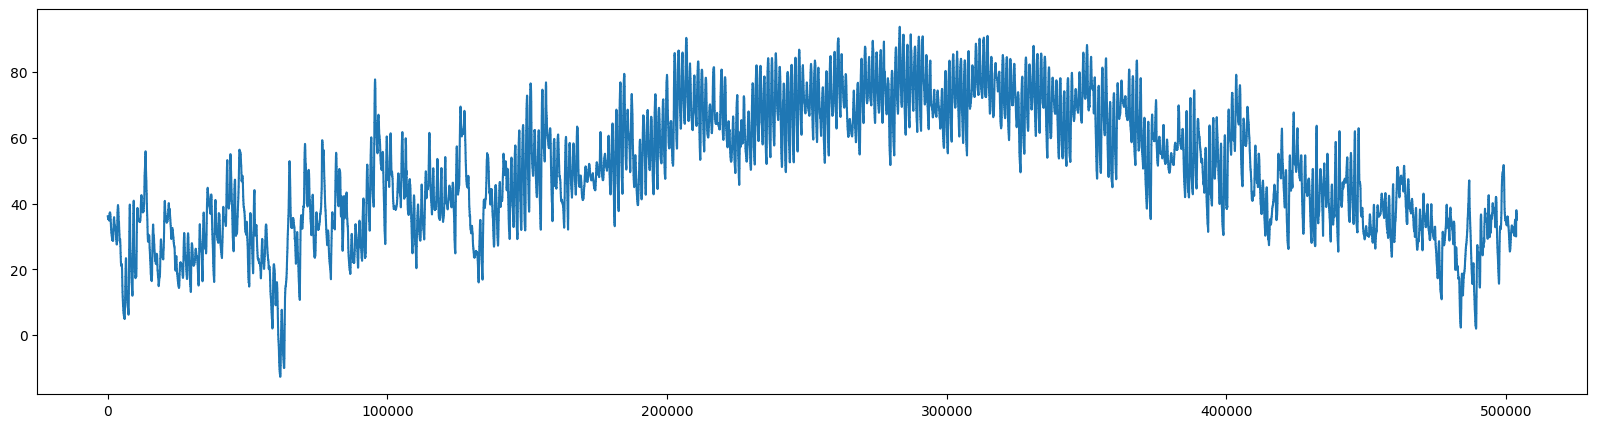

In [48]:
df['temperature'].plot(figsize=(20,5))

In [49]:
#renaming and dropping some columns
df['use_HO'] = df['use']
df['gen_Sol'] = df['gen']
df.drop(['use','House overall','gen','Solar'], axis=1, inplace=True)

In [50]:
df.head(2)

,time,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,Garage door,Kitchen 12,Kitchen 14,...,year,month,day,weekday,weekofyear,hour,minute,timing,use_HO,gen_Sol
0,2016-01-01 05:00:00,0.000033,0.020700,0.061917,0.442633,0.12415,0.006983,0.013083,0.000417,0.00015,...,2016,1,1,Friday,53,5,0,Morning,0.932833,0.003483
1,2016-01-01 05:01:00,0.000000,0.020717,0.063817,0.444067,0.12400,0.006983,0.013117,0.000417,0.00015,...,2016,1,1,Friday,53,5,1,Morning,0.934333,0.003467


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
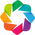

:Layout
   .Distribution.I  :Distribution   [use_HO]   (Density)
   .Distribution.II :Distribution   [gen_Sol]   (Density)

In [52]:
import holoviews as hv
hv.extension("bokeh")
use_distribution = hv.Distribution(df['use_HO']).options(
    title="Total Energy Consumption Distribution",
    color="red"
)
gen_distribution = hv.Distribution(df['gen_Sol']).options(
    title="Total Energy Generation Distribution",
    color="blue"
)
combined_plot = (use_distribution + gen_distribution).options(
    hv.opts.Distribution(
        xlabel="Energy Consumption",
        ylabel="Density",
        xformatter='%.1fkw',
        width=400,
        height=300,
        tools=['hover'],
        show_grid=True,
    )
)

# Display the combined plot
combined_plot

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
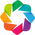

:Curve   [time]   (use_HO)

In [53]:
#have to import holoview each time to view the img
import holoviews as hv
hv.extension("bokeh")
# Assuming df is your DataFrame
df = df.set_index(df['time'])

use_curve = hv.Curve(df['use_HO'].resample('D').mean()).options(
    title="Total Energy Consumption Time-Series by Day",
    color="red",
    ylabel="Energy Consumption",
    tools=['hover'],
    show_grid=True,
    fontsize={'title': 11},
    toolbar='above',  # Specify the toolbar position explicitly
).options(
    hv.opts.Curve(
        xlabel="Day",
        yformatter='%.1fkw',
        width=400,
        height=300,
        active_tools=['pan', 'wheel_zoom']  # Specify the active tools
    )
)

# Display the plot for "Total Energy Consumption Time-Series by Day"
use_curve

In [54]:
# Feature Engineering
def preprocess_data(df):
    lgbm_df = df.resample('H').mean()
    lgbm_df['weekday'] = LabelEncoder().fit_transform(lgbm_df.index.day_name()).astype(np.int8)
    lgbm_df['timing'] = LabelEncoder().fit_transform(lgbm_df['hour'].apply(hours2timing)).astype(np.int8)
    return lgbm_df

print(preprocess_data(df=df))

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


                     Dishwasher  Furnace 1  Furnace 2  Home office    Fridge  \
time                                                                           
2016-01-01 05:00:00    0.000064   0.134631   0.258557     0.241814  0.037861   
2016-01-01 06:00:00    0.000099   0.236570   0.220138     0.043294  0.075522   
2016-01-01 07:00:00    0.000043   0.099424   0.272746     0.043416  0.059486   
2016-01-01 08:00:00    0.000138   0.375153   0.241217     0.065014  0.060412   
2016-01-01 09:00:00    0.000060   0.153000   0.190842     0.043392  0.035106   
...                         ...        ...        ...          ...       ...   
2016-12-15 23:00:00    0.000075   0.286136   0.486331     0.041853  0.044236   
2016-12-16 00:00:00    0.000059   0.297272   0.498734     0.041711  0.050492   
2016-12-16 01:00:00    0.000100   0.340873   0.482545     0.041921  0.049140   
2016-12-16 02:00:00    0.000085   0.272381   0.434319     0.041900  0.050063   
2016-12-16 03:00:00    0.000072   0.3310

In [69]:
def lgbm_train(df, cols=['temperature','dewPoint','use_HO'], trg='use_HO', train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    lgbm_df = preprocess_data(df)[cols]

    tr, vd, te = [int(len(lgbm_df) * i) for i in [train_ratio, valid_ratio, test_ratio]]

    X_train, Y_train = lgbm_df.iloc[:tr].drop([trg], axis=1), lgbm_df.iloc[:tr][trg]
    X_valid, Y_valid = lgbm_df.iloc[tr:tr+vd].drop([trg], axis=1), lgbm_df.iloc[tr:tr+vd][trg]
    X_test = lgbm_df.iloc[tr+vd:tr+vd+te+2].drop([trg], axis=1)

    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_valid = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

    # Model training with early stopping rounds in the params dictionary
    params = {
        'task': 'train',
        'boosting': 'gbdt',
        'objective': 'regression',
        'metric': {'mse'},
        'num_leaves': 200,
        'drop_rate': 0.05,
        'learning_rate': 0.1,
        'seed': 0,
        'feature_fraction': 1.0,
        'bagging_fraction': 1.0,
        'bagging_freq': 0,
        'min_child_samples': 5,
        'early_stopping_rounds': 100  # Early stopping rounds parameter
    }

    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_valid])

    # Make predict dataframe
    pre_df = pd.DataFrame()
    pre_df[trg] = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    pre_df.index = lgbm_df.index[tr+vd:tr+vd+te+2]

    return pre_df, gbm, X_train


In [70]:
lgbmForecast_df, model, x_train = lgbm_train(df=df, cols=['temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability','year', 'month','day', 'weekday', 'weekofyear', 'hour', 'timing','use_HO'], trg='use_HO',train_ratio=0.9,valid_ratio=0.09,test_ratio=0.01)



The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2929
[LightGBM] [Info] Number of data points in the train set: 7559, number of used features: 17
[LightGBM] [Info] Start training from score 0.854427
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	training's l2: 0.0530046	valid_1's l2: 0.194983


In [73]:
# Example usage
# lgbmForecast_df, model, x_train = lgbm_train(
#     df=df,
#     cols=['temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
#           'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'year', 'month', 'day', 'weekday',
#           'weekofyear', 'hour', 'timing', 'use_HO'],
#     trg='use_HO',
#     train_ratio=0.9,
#     valid_ratio=0.09,
#     test_ratio=0.01
# )

# Calculate SHAP value for model interpretation
explainer = shap.TreeExplainer(model=model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X=x_train)